### 0.Softmax

In [1]:
import numpy as np

In [19]:
vector = np.array([11231, 999, 123142])

In [28]:
vector = np.array([-10, 10, 24])

In [33]:
def softmax(vec):
    vec -= np.max(vec)
    exp = np.exp(vec)
    return exp / np.sum(exp)

In [32]:
softmax(vector)

array([1.71390701e-15, 8.31528028e-07, 9.99999168e-01])

In [2]:
import jieba
from gensim.models.word2vec import LineSentence
import re
import nltk
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import smart_open
import os
%matplotlib inline

from hanziconv import HanziConv

### 1.数据处理
* 数据下载
* 数据解压 -- [Python wikipedia extracotr](https://github.com/attardi/wikiextractor)

In [5]:
# 处理单个1M语料
with open('wiki_00', 'r', encoding='utf-8') as f1:
    with open('wiki_00_cut', 'w', encoding='utf-8') as f2:
        for each_line in f1:
            if each_line.strip():
                temp_result = []
                to_simplified = HanziConv.toSimplified(each_line)
                get_char = re.findall('[\u4e00-\u9fa5]+', to_simplified)
                for each in get_char:
                    temp_result += list(jieba.cut(each))

                f2.write(' '.join(temp_result) + '\n')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.834 seconds.
Prefix dict has been built succesfully.


In [ ]:
# 处理所有数据，生成对应1M空格隔开的语料
count = 0
    target_path = 'D:\\Github\\NLP\\Artificial_Intelligence_for_NLP\\Week_04_0727\\data\\text'
    for x in os.listdir(target_path):
        if os.path.isdir(x):
            target_ = os.path.abspath(x)
            for file in os.listdir(target_):
                file_path = os.path.join(target_, file)
                file_name, ext = os.path.splitext(file_path)
                if not ext:
                    with open(file_name, 'r', encoding='utf-8') as f1:
                        count += 1
                        percentage = (count / 1298)*100
                        print(f"{percentage: .2f} %")
                        with open('wiki_cut_' + str(count), 'w', encoding='utf-8') as f2:
                            for each_line in f1:
                                if each_line.strip():
                                    temp_result = []
                                    to_simplified = HanziConv.toSimplified(each_line)
                                    get_char = re.findall('[\u4e00-\u9fa5]+', to_simplified)
                                    for each in get_char:
                                        temp_result += list(jieba.cut(each))

                                    f2.write(' '.join(temp_result) + '\n')

In [ ]:
# 方法1：合并1298个wiki文件后统一训练
count_ = 0
taget_path = 'D:\\Github\\NLP\\Artificial_Intelligence_for_NLP\\Week_04_0727\\data\\clean_text'
for file in os.listdir(taget_path):
    count_ += 1
    if count_ % 30 == 0:
        percentage = (count_ / 1298) * 100
        print(f"Processing percentage: {percentage: .2f} %")
    file_path = os.path.join(taget_path, file)
    with open(file_path, 'r', encoding='utf-8') as f1:
        with open('wiki_all', 'a', encoding='utf-8') as f2:
            f2.writelines(f1.readlines())

In [4]:
with open('wiki_all', 'r', encoding='utf-8') as f:
    print(len(f.readlines()))

7654851


### 2.模型训练

In [37]:
# 训练以及可视化过程比较长，添加结束装饰器进行提醒
import winsound
import time
from functools import wraps

def beep_alarm(func):
    @wraps(f)
    def wrap(*args, **kw):
        result = func(*args, **kw)
        duration = 1000
        freq = 440
        for _ in range(5):
            winsound.Beep(freq, duration)
            time.sleep(.5)
        return result
    return wrap

In [41]:
data_file = 'D:\\Github\\NLP\\Artificial_Intelligence_for_NLP\\Week_04_0727\\Assignment\\wiki_all'
wiki_sentences = LineSentence(smart_open.open(data_file, 'r', encoding='utf-8'))

In [7]:
model_wiki = Word2Vec(wiki_sentences, size=200, window=10, min_count=20, workers=4)

In [ ]:
model_wiki.save('word2vec_wiki.model')

In [42]:
# 整理成函数
@beep_alarm
def model_train(file_path:str, model_name:str):
    """
    @file_path: target file abspath
    @model_name: trained model's name
    """
    open_file = smart_open.open(file_path, 'r', encoding='utf-8')
    sentences = LineSentence(open_file)
    model = Word2Vec(sentences, size=200, window=10, min_count=20, workers=4)
    model.save(model_name)
    return model

In [ ]:
# 方法2：多个语料追加训练
taget_path = 'D:\\Github\\NLP\\Artificial_Intelligence_for_NLP\\Week_04_0727\\data\\clean_text'
count = 0
for file in os.listdir(taget_path):
    model = Word2Vec.load('word2vec.model')
    file_path = os.path.join(taget_path, file)
    open_file = smart_open.open(file_path, 'r', encoding='utf-8')
    sentences = LineSentence(open_file)
    length = len(list(sentences))
    model.train(sentences=sentences,total_examples=length, epochs=1)
    
    count += 1
    if count % 30 == 0:
        model.save('word2vec.model')
        percentage = (count / 1298) * 100
        print(f"Processing percentage: {percentage: .2f} %")

### 3.同义词测试

In [10]:
model_wiki.wv.most_similar('父亲')

[('母亲', 0.8864368796348572),
 ('外祖父', 0.7837424874305725),
 ('其父', 0.7638671398162842),
 ('舅舅', 0.7623937726020813),
 ('叔叔', 0.7584229707717896),
 ('哥哥', 0.7532105445861816),
 ('继父', 0.7473486065864563),
 ('外祖母', 0.7249664068222046),
 ('弟弟', 0.7232440114021301),
 ('祖母', 0.7182639241218567)]

In [11]:
model_wiki.wv.most_similar('科学')

[('自然科学', 0.7531071901321411),
 ('科学研究', 0.7447824478149414),
 ('科学知识', 0.6744067668914795),
 ('现代科学', 0.6667987108230591),
 ('基础科学', 0.6627198457717896),
 ('物理', 0.6622257828712463),
 ('生命科学', 0.6505856513977051),
 ('生物学', 0.6445862650871277),
 ('生态学', 0.6433760523796082),
 ('学术', 0.6399204730987549)]

In [12]:
model_wiki.wv.most_similar('总统')

[('国防部长', 0.7399734258651733),
 ('总理', 0.7333885431289673),
 ('司法部长', 0.695505678653717),
 ('国务卿', 0.688080370426178),
 ('民选总统', 0.6808322072029114),
 ('内政部长', 0.676962673664093),
 ('外交部长', 0.6573377847671509),
 ('代总统', 0.6503158211708069),
 ('布什总统', 0.6438124775886536),
 ('财政部长', 0.6399596929550171)]

In [21]:
model_wiki.wv.most_similar('好看')

[('漂亮', 0.7294697761535645),
 ('好笑', 0.7188972234725952),
 ('难看', 0.7024850845336914),
 ('吓人', 0.7018975615501404),
 ('讨喜', 0.6970889568328857),
 ('有意思', 0.6956104040145874),
 ('好吃', 0.6794742345809937),
 ('好听', 0.6653374433517456),
 ('做作', 0.6642213463783264),
 ('厉害', 0.6624077558517456)]

In [22]:
model_wiki.wv.most_similar('美国')

[('英国', 0.6538125276565552),
 ('美国政府', 0.6293367743492126),
 ('纽约', 0.5975532531738281),
 ('加拿大', 0.5953937768936157),
 ('澳大利亚', 0.5743899345397949),
 ('全美', 0.5653631687164307),
 ('北美', 0.5598125457763672),
 ('墨西哥', 0.559592604637146),
 ('美国联邦', 0.5583969354629517),
 ('纽约州', 0.5381714105606079)]

### 4.可视化
> [参考](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne)

In [13]:
len(model_wiki.wv.vocab)

246868

In [17]:
from sklearn.manifold import TSNE

In [38]:
@beep_alarm
def tsne_plot(model, count=1000):
    labels = []
    tokens = []
    
    count = count
    for word in model.wv.vocab:
        tokens.append(model.wv[word])
        labels.append(word)
        count += 1
        if count > 1000:
            break
        
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20,20))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                    xy=(x[i], y[i]),
                    xytext=(5,2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
    plt.show()

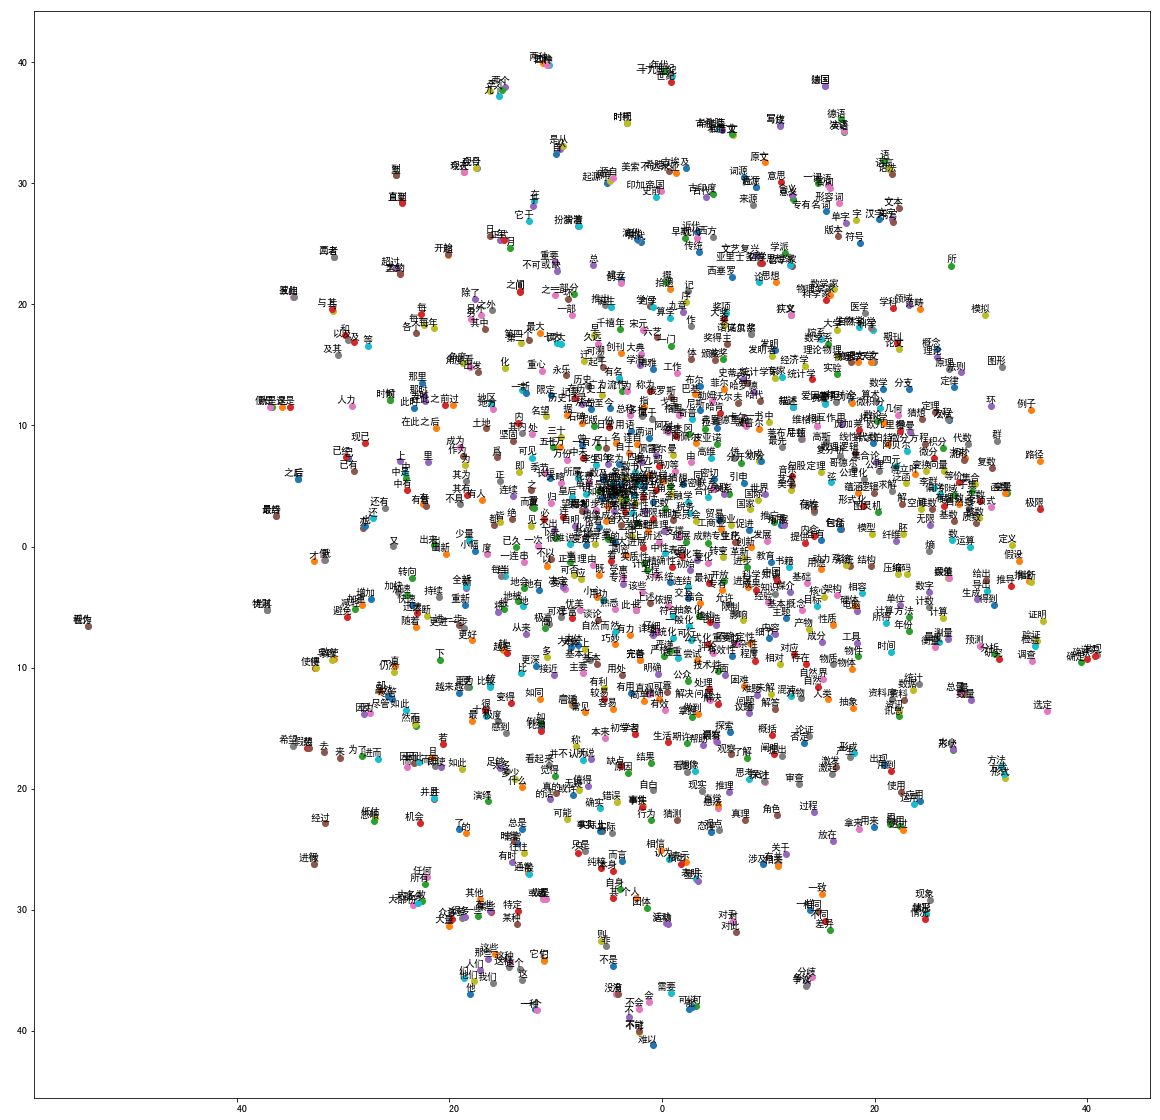

In [20]:
tsne_plot(model_wiki)

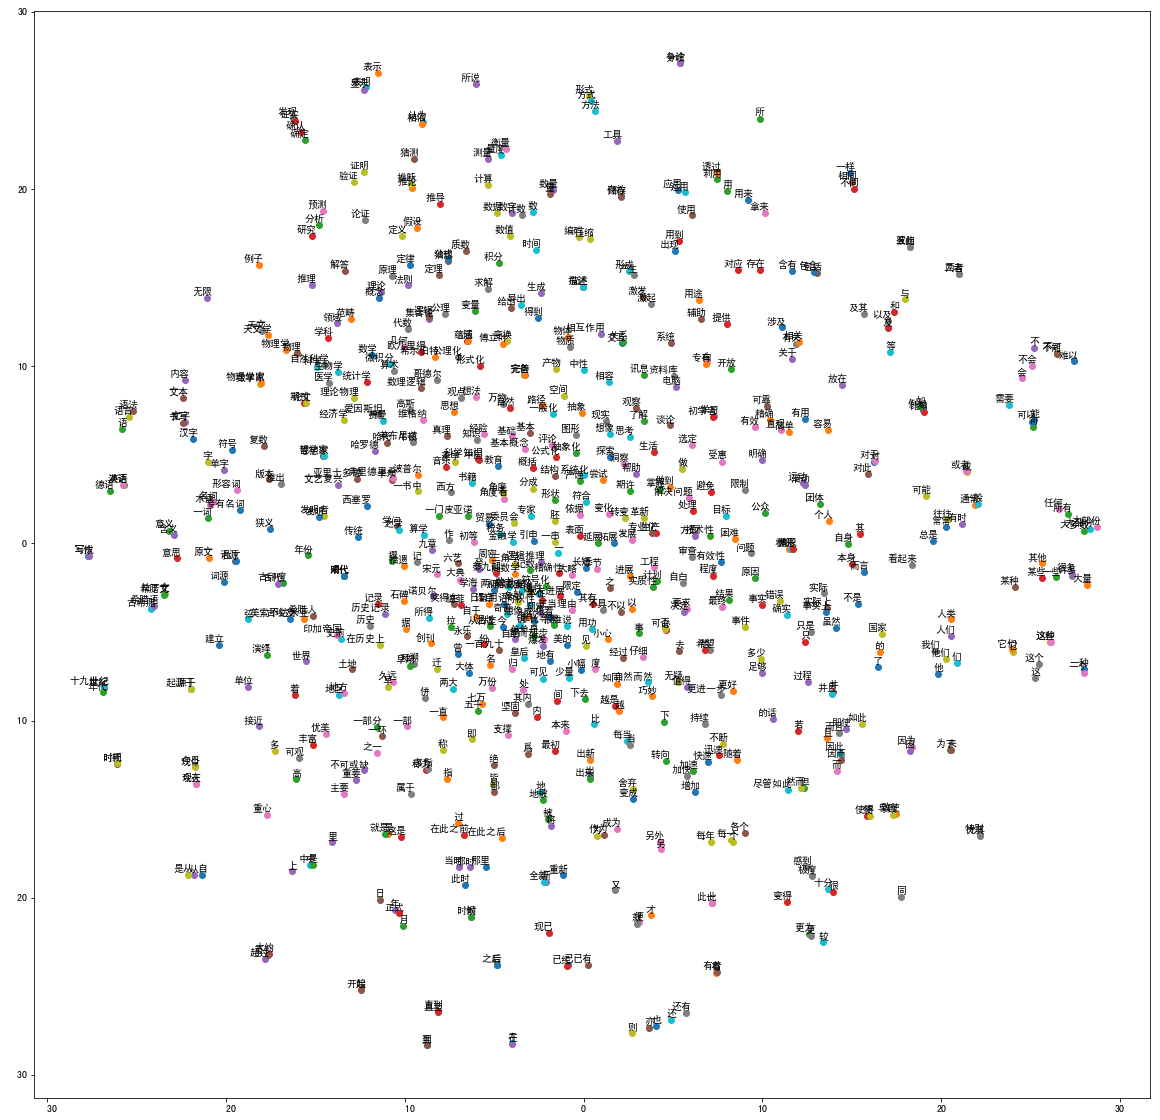

In [39]:
tsne_plot(model_wiki, 300)